## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [29]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from architecture.fno_1d import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import LinearOperator #, gmres
from operators.stokes_operator import StokesAdjointBoundaryOp
from boundary_solvers.geometry_torch_ops import unpack_data, unpack, subsample, integrate, subdict, concat_dict_entries, to_dtype
from boundary_solvers.geometry_torch_ops import arclength, normalize, curvature, invariant_quantities, project_to_natural, to_device
from torch.nn.utils import clip_grad_norm_
from util.unet import *
import torch.nn as nn
import time
from torch.utils.data import Dataset, DataLoader

## Create data loader

Load and transform the data. 

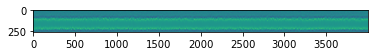

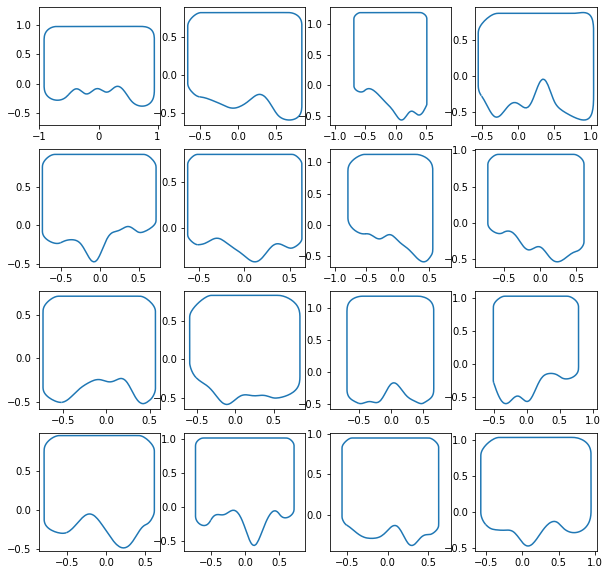

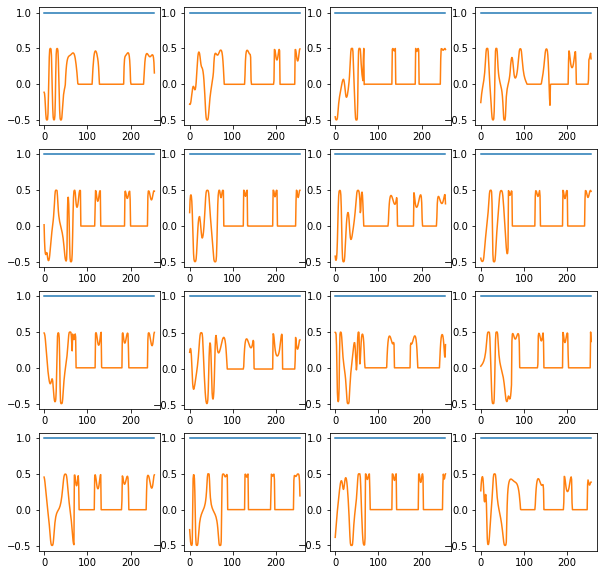

In [31]:
device = "cuda:0"

#dir = "/home/emastr/phd/data/micro_geometries_line_pos_hd_repar_torch"
dir = "/home/emastr/phd/data/micro_geometries_boundcurv_repar_256_torch"
# Load and transform
data = to_device(torch.load(f"{dir}/data_{0}.torch"), device)

for i in [0]:
    data_ = to_device(torch.load(f"{dir}/data_{i}.torch"), device)
    for k in data.keys():
        if isinstance(data[k], torch.Tensor):
            data[k] = torch.cat((data[k], data_[k]), dim=0)

inp, out = unpack_data(data)


def mean_distance(data):
    center_x = torch.mean(data['x']*data['w'], axis=1)[:, None]
    center_y = torch.mean(data['y']*data['w'], axis=1)[:, None]    
    return ((data['x'] - center_x)**2 + (data['y'] - center_y)**2)**0.5

    
dtype = torch.double
inp, out = to_dtype(inp, dtype), to_dtype(out, dtype)

# Add invariant quantities to data.
inp.update(invariant_quantities(inp))

inp.update({'dist': mean_distance(inp)})

inp_project_to_natural = ['v', 'dv']
out_project_to_natural = ['r', 'dr']
inp.update(project_to_natural(inp_project_to_natural, inp['tx'], inp['ty'], inp))
out.update(project_to_natural(out_project_to_natural, inp['tx'], inp['ty'], out))


# Normalise curvature using monotone function sigmoid(x/2) - 1/2.
inp['c'] = 1/(1 + torch.exp(-0.5 * inp['c'])) - 0.5 
   
plt.imshow(inp['dvy'][:,:].cpu().T)

plt.figure(figsize=(10,10))
n_plot = 4
for i in range(n_plot*n_plot):
    plt.subplot(n_plot, n_plot, i+1)
    x, y = inp["x"][i, :].cpu().numpy(), inp["y"][i, :].cpu().numpy()
    plt.plot(x, y)
    plt.axis("equal")
    
plt.figure(figsize=(10,10))
for i in range(n_plot*n_plot):
    plt.subplot(n_plot, n_plot, i+1)
    dx, dy = inp["tx"][i, :].cpu().numpy(), inp["ty"][i, :].cpu().numpy() 
    c = inp["c"][i, :].cpu().numpy()
    plt.plot(dx**2 + dy**2)
    plt.plot(c)
    

Split into training and test data

In [21]:
feature_setup = 5
random_roll = True

# Standard features (coordinates, derivatives of parameterisation)
if feature_setup == 1:
    inp_features = ['x', 'y', 'dx','dy','ddx','ddy','vx','vy', 'dvx', 'dvy']
    out_features = ['rx', 'ry', 'drx', 'dry']
    v_features = ['vx','vy', 'dvx', 'dvy']
    
# Invariant features (coordinates, tangent, curvature)
elif feature_setup == 2:
    inp_features = ['x', 'y', 'tx', 'ty', 'c', 'vx', 'vy', 'dvx', 'dvy']
    out_features = ['rx', 'ry', 'drx', 'dry']
    v_features = ['vx', 'vy', 'dvx', 'dvy']

# Invariant features, projected cordinates, MINIMAL
elif feature_setup == 3:
    inp_features = ['x', 'y', 'tx', 'ty', 'c', 'vt', 'vn', 'dvt', 'dvn']
    out_features = ['rt', 'rn', 'drt', 'drn']
    v_features = ['vt', 'vn', 'dvt', 'dvn']

# Invariant features, projected cordinates, MINIMAL
elif feature_setup == 4:
    inp_features = ['c', 'vt', 'vn', 'dvt', 'dvn']
    out_features = ['rt', 'rn', 'drt', 'drn']
    v_features = ['vt', 'vn', 'dvt', 'dvn']
    
# Invariant features, projected cordinates, MINIMAL, with distance to center
elif feature_setup == 5:
    inp_features = ['c', 'dist','vt', 'vn', 'dvt', 'dvn']
    out_features = ['rt', 'rn', 'drt', 'drn']
    v_features = ['vt', 'vn', 'dvt', 'dvn']

# Reduced features (trust fourier transform to handle the rest)
#features = {'x', 'y', 'vx', 'vy'}

def avg(f, g, dx, dy, w):
    return np.sum(np.real(np.conjugate(1j * f) * g) * (dx**2 + dy**2) ** 0.5 * w)

def test_eval(idx_test, net):
    x = dat_test["x"][idx_test].cpu().numpy()
    y = dat_test["y"][idx_test].cpu().numpy()
    dx = dat_test["dx"][idx_test].cpu().numpy()
    dy = dat_test["dy"][idx_test].cpu().numpy()
    tx = dat_test["tx"][idx_test].cpu().numpy()
    ty = dat_test["ty"][idx_test].cpu().numpy()
    w  = dat_test["w"][idx_test].cpu().numpy()
    rx = dat_test["rx"][idx_test].cpu().numpy()
    ry = dat_test["ry"][idx_test].cpu().numpy()
    drx = dat_test["drx"][idx_test].cpu().numpy()
    dry = dat_test["dry"][idx_test].cpu().numpy()

    c = 4j + 1
    test_vec = np.conjugate(x + 1j * y) - c
    net_out = net(X_test[idx_test:idx_test+1])[0, :4].cpu().detach().numpy() ## rx, ry

    if out_features[0] == 'rt':
        rx_net = net_out[0, :] * tx - net_out[1, :] * ty
        ry_net = net_out[0, :] * ty + net_out[1, :] * tx

        drx_net = net_out[2, :] * tx - net_out[3, :] * ty
        dry_net = net_out[2, :] * ty + net_out[3, :] * tx
    else:
        rx_net = net_out[0, :]
        ry_net = net_out[1, :]

        drx_net = net_out[2, :]
        dry_net = net_out[3, :]

    net_apx = avg(test_vec, rx_net + 1j * ry_net, dx, dy, w)
    num_apx = avg(test_vec, rx + 1j*ry, dx, dy, w)

    dnet_apx = avg(test_vec, drx_net + 1j * dry_net, dx, dy, w)
    dnum_apx = avg(test_vec, drx + 1j*dry, dx, dy, w)

    e = abs(net_apx - num_apx)
    de = abs(dnet_apx - dnum_apx)

    return e / (1e-3 + abs(net_apx)), de / (1e-3 + abs(dnet_apx))

## TRAINING DATA

M_train = 2000#0
M_batch = 32 # 20 # Batch
idx_train = list(range(M_train))
dat_train = subsample(inp, idx_train)
dat_train.update(subsample(out, idx_train))
X_train = concat_dict_entries(subdict(dat_train, inp_features))
V_train = concat_dict_entries(subdict(subsample(inp, idx_train), v_features))
Y_train = concat_dict_entries(subdict(subsample(out, idx_train), out_features))
#X_train = subdict(X_train, {'vx', 'vy'})

## TEST DATA
M_test = 200#0
idx_test = list(range(M_train, M_test + M_train))
dat_test = subsample(inp, idx_test)
dat_test.update(subsample(out, idx_test))
X_test = concat_dict_entries(subdict(dat_test, inp_features))
V_test = concat_dict_entries(subdict(subsample(inp, idx_test), v_features))
Y_test = concat_dict_entries(subdict(subsample(out, idx_test), out_features))
#X_test = subdict(X_test, {'vx', 'vy'})

in_channels = len(inp_features)
out_channels = 4

Create network

In [22]:
save_name = "fnoskip_big_data_25"

settings = {"modes": 40,
            "input_features": inp_features,
            "output_features": out_features,
            "weight_decay": 0,#0.000001,
            "layer_widths": [3*len(inp_features),] * 8,#8,
            "skip": True,
            "amsgrad":False}


net = FNO1d(modes=settings["modes"], 
            in_channels=in_channels, 
            out_channels=out_channels, 
            layer_widths=settings["layer_widths"])


net.to(device)

if settings["skip"]:
    class SkipNet(nn.Module):
        def __init__(self, net):
            super(SkipNet, self).__init__()
            self.net = net
            
        def forward(self, x):
            return self.net(x) + x[:, -4:, :]
    net = SkipNet(net)
None

Do training

In [23]:
N = 20001 #50001 #30001

# Predefine list of losses 
trainloss = []
testloss  = []
sliploss = []

# Loss function
def loss_fcn(x, y):
    y_norm = torch.linalg.norm(y, dim=2)[:,:,None]
    #er_norm = torch.linalg.norm(x - y, dim=2)
    return torch.mean((x - y)**2 / y_norm**2)#L1Loss()
    
loss_save = nn.MSELoss()
benchloss = loss_fcn(V_test, Y_test).item()
#optim     = torch.optim.AdamW(net.parameters(), weight_decay=settings["weight_decay"])
optim     = torch.optim.Adam(net.parameters(), weight_decay=settings["weight_decay"], amsgrad=settings["amsgrad"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=0.01, total_steps=N)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=1000, T_mult=1, eta_min=0.0001)


# DO TRAINING LOOP 
##################################################
for i in range(N):
    optim.zero_grad()
    
    idx_batch = torch.randperm(M_train)[:M_batch] 
    if random_roll:
        roll = np.random.randint(0, X_train.shape[2])
    else:
        roll = 0
        
    Y_batch   = torch.roll(Y_train[idx_batch], shifts=roll, dims=2)
    X_batch   = torch.roll(X_train[idx_batch], shifts=roll, dims=2)
    
    # Train on truncated net that expands as iterations progress
    loss = loss_fcn(net(X_batch), Y_batch)
    loss.backward()
    grad_max = max([p.grad.detach().abs().max() for p in net.parameters() if p.grad is not None])
    #clip_grad_norm_(net.parameters(), 1e-3, norm_type=2.0)
    optim.step()
    #scheduler.step()

    # Test 
    trainloss.append(loss.item() ** 0.5)
    testloss.append(loss_save(net(X_test), Y_test).item() ** 0.5)

    idx_test = np.random.randint(0, X_test.shape[0])
    r_er, dr_er = test_eval(idx_test, net)
    sliploss.append((r_er, dr_er))
        
    
    if i % 100 == 0:
        torch.save({"state dict" : net.state_dict(), 
                    "settings"   : settings,
                    "trainloss"  : trainloss,
                    "testloss"   : testloss,
                    "testloss slip": sliploss}, 
                    f"/home/emastr/phd/data/runs/{save_name}_{i}.Torch") 
        
    print(f"Step {i}. Train loss = {trainloss[-1]:.2e}, test loss = {testloss[-1]:.2e}, benchmark={benchloss:.2e}, vel avg err ={sliploss[-1][0]:.2e}, dvel avg err ={sliploss[-1][1]:.2e}, grad norm = {grad_max:.2e}", end="\r")

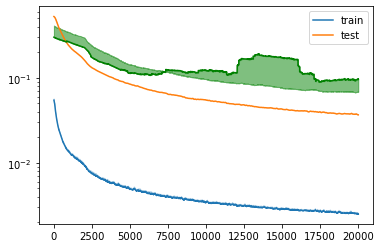

In [24]:
save = torch.load(f"/home/emastr/phd/data/runs/{save_name}_{20000}.Torch")
#save = torch.load(f"/home/emastr/phd/data/fno_adjoint_state_dict_2022_12_02_default25_{30000}.Torch")

trainloss = save["trainloss"]
testloss = save["testloss"]
sliploss = np.array([s[0] for s in save["testloss slip"]])
settings = save["settings"]


net = FNO1d(modes=settings["modes"], 
            in_channels=len(settings["input_features"]), 
            out_channels=len(out_features),#len(settings["output_features"]), 
            layer_widths=settings["layer_widths"])

net.to(device)

if settings["skip"]:
    class SkipNet(nn.Module):
        def __init__(self, net):
            super(SkipNet, self).__init__()
            self.net = net
            
        def forward(self, x):
            return self.net(x) + x[:, -4:, :]
    net = SkipNet(net)

net.load_state_dict(save["state dict"])

quantiles = np.array([0.8]) # 80% percentile upper bound
iters = np.linspace(0,len(trainloss),len(trainloss))
window = 100
plot_quantiles(plt.gca(), iters, trainloss, quantiles, window, label='train')
plot_quantiles(plt.gca(), iters, testloss, quantiles, window, label='test')
plot_quantiles(plt.gca(), iters, sliploss, quantiles, window=4000, color='green')
plt.yscale("log")
plt.legend()

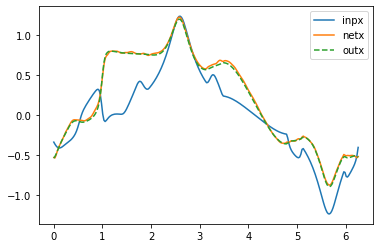

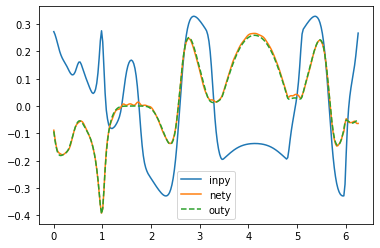

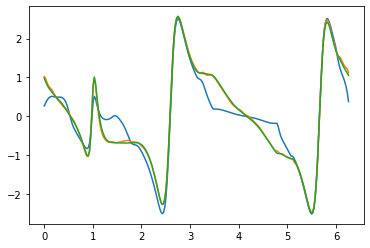

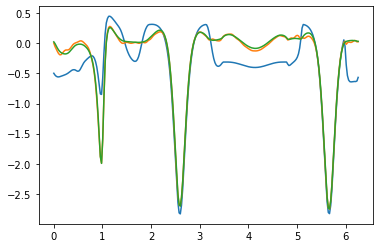

In [27]:
Y_net = net(X_test).cpu()
Y_net = Y_net.detach()

idx = 1

for i in [idx]:
    t = dat_test['t'][i, :].cpu()
    
    # Tangent vector components
    t_x = dat_test['tx'][i, :].cpu()
    t_y = dat_test['ty'][i, :].cpu()
    
    #t_x = torch.ones_like(t)
    #t_y = torch.zeros_like(t)
    
    # X components of velocity and network output
    #v_tx = V_test[i, 0, :]
    #y_tx = Y_test[i, 0, :]
    #y_nx = Y_net[i, 0, :]
    
    # Y components of velocity and network output
    #v_ty = V_test[i, 1, :]
    #y_ty = Y_test[i, 1, :]
    #y_ny = Y_net[i, 1, :]
    
    # Project velocity onto tangent and normal vectors
    vt_proj_t = V_test[i, 0, :].cpu()
    vt_proj_n = V_test[i, 1, :].cpu()
    
    yt_proj_t = Y_test[i, 0, :].cpu()
    yt_proj_n = Y_test[i, 1, :].cpu()
    
    yn_proj_t = Y_net[i, 0, :].cpu()
    yn_proj_n = Y_net[i, 1, :].cpu()
    
    #vt_proj_t = t_x * v_tx + t_y * v_ty
    #vt_proj_n = t_x * v_ty - t_y * v_tx
    
    #yt_proj_t = t_x * y_tx + t_y * y_ty
    #yt_proj_n = t_x * y_ty - t_y * y_tx
    
    #yn_proj_t = t_x * y_nx + t_y * y_ny
    #yn_proj_n = t_x * y_ny - t_y * y_nx
    
    
    
    plt.figure(1)
    plt.plot(t, vt_proj_t, label='inpx')
    plt.plot(t, yn_proj_t, label='netx')
    plt.plot(t, yt_proj_t, '--', label='outx')
    plt.legend()
    
    plt.figure(2)
    plt.plot(t, vt_proj_n, label='inpy')
    plt.plot(t, yn_proj_n, label='nety')
    plt.plot(t, yt_proj_n, '--', label='outy')
    plt.legend()
    
    
    plt.figure(3)
    plt.plot(t, V_test[i, 2, :].cpu())
    plt.plot(t, Y_net[i, 2, :].cpu())
    plt.plot(t, Y_test[i, 2, :].cpu())
    
    plt.figure(4)
    plt.plot(t, V_test[i, 3, :].cpu())
    plt.plot(t, Y_net[i, 3, :].cpu())
    plt.plot(t, Y_test[i, 3, :].cpu())
    

# plt.figure(5)
# plt.plot(inp['x'][idx, :], inp['y'][idx, :])
# plt.quiver(inp['x'][idx,:], inp['y'][idx,:], inp['dy'][idx,:], -inp['dx'][idx,:])
# plt.quiver(inp['x'][idx,:], inp['y'][idx,:], inp['ddx'][idx,:], inp['ddy'][idx,:], color='red')
# plt.quiver(inp['x'][idx,:], inp['y'][idx,:], inp['vy'][idx,:], inp['vx'][idx,:], color='green')
# plt.axis("equal")

invariant, projecting
3.413735072399504e-09
0.05590095252657323


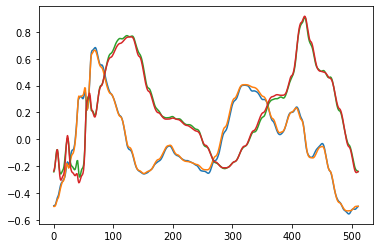

In [18]:
idx_test = 120



data = torch.load(f"/home/emastr/phd/data/micro_geometries_boundcurv/domain_{M_train + idx_test}.GPDomain")
data.pop("precomp")
data.pop("precomp_der")
data.pop("intermediate_precomp")
data.pop("intermediate_precomp_der")
data.pop("error")

x = dat_test["x"][idx_test].cpu().numpy()
y = dat_test["y"][idx_test].cpu().numpy()

dx = dat_test["dx"][idx_test].cpu().numpy()
dy = dat_test["dy"][idx_test].cpu().numpy()

tx = dat_test["tx"][idx_test].cpu().numpy()
ty = dat_test["ty"][idx_test].cpu().numpy()

w  = dat_test["w"][idx_test].cpu().numpy()

rx = dat_test["rx"][idx_test].cpu().numpy()
ry = dat_test["ry"][idx_test].cpu().numpy()


mg = GPDomain.load(data)
# mg.plot(ax=plt.gca())
# plt.plot(x, y)
# plt.axis("equal")

c = 1j + 1
vec = np.conjugate(mg.eval_param()) - c
a = mg.line_left - c
b = mg.line_right - c
tru = np.real(b**2 - a**2)/2

net_out = net(X_test[idx_test:idx_test+1])[0, :2].cpu().detach().numpy() ## rx, ry

if out_features[0] == 'rt':
    print("invariant, projecting")
    rx_net = net_out[0, :] * tx - net_out[1, :] * ty
    ry_net = net_out[0, :] * ty + net_out[1, :] * tx
else:
    rx_net = net_out[0, :]
    ry_net = net_out[1, :]


plt.plot(rx_net)
plt.plot(rx)

plt.plot(ry_net)
plt.plot(ry)
net_apx = mg.inner(1j*vec, rx_net + 1j * ry_net)

#num_apx = mg.inner(1j*vec, rx + 1j * ry)
num_apx = np.sum((np.conjugate(1j * vec) * (rx + 1j*ry)).real * (dx**2 + dy**2)**0.5 * w)

er_num = abs(num_apx - tru)
er_net = abs(net_apx - tru)



print(er_num)
print(er_net)